## Bikes CNN for Price Regression

### Imports

--------------

We use Keras to build and train our model, with a Tensorflow backend. We use scikit-learn for evaluation metrics.

In [1]:
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Using TensorFlow backend.


### Load data on file paths and prices, as well as train/test split

--------------------

We load the locations of the images, as well as the train/test split. We use a 90/10 split, which we share across the neural network and baselines.

In [2]:
# read the CSV into memory
prices = []
image_paths = []

data_path = "../datasets/bikes_im/"
with open("../datasets/bikes_filtered.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = row[2]
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(int(msrp))

train_indices = np.load("bikes_train_indices.npy")
test_indices = np.load("bikes_test_indices.npy")
print(train_indices.shape)
print(test_indices.shape)

(19658,)
(2185,)


### Initialize Image Generator

Due to the size of our dataset (>20,000 images), we cannot read all images into memory. Thus, we write our own image generator, which is a Python generator that reads images a minibatch at a time, preprocessing them and returning the input data and price labels as input to the neural network.

In [3]:
def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 1))
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 1))
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)                
                Y[i] = prices[index]
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
            
            yield (X, Y)

### Hyperparameters

We tune hyperparameters using grid search and random search, modifying one hyperparameter at a time while keeping the others constant.

In [4]:
# Hyperparameters

num_settings = 1

hp_dropout = [0.2] * num_settings

#RMSprop
hp_lr = [0.001] * num_settings
hp_rho = [0.9] * num_settings
hp_epsilon = [1e-07] * num_settings
hp_decay = [0.0] * num_settings

# Number of hidden units
hp_hidden = [256] * num_settings

# Minibatch size
hp_mbsize = [64] * num_settings

num_epochs = 20

58523648/58889256 [============================>.] - ETA: 0s

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=308, epochs=20, validation_data=<generator..., callbacks=[<keras.ca..., validation_steps=35)`


Epoch 1/20
308/308 [==============================] - 247s - loss: 1304577.6025 - val_loss: 1171789.8649
Epoch 2/20
308/308 [==============================] - 232s - loss: 873493.7291 - val_loss: 771802.7910
Epoch 3/20
308/308 [==============================] - 232s - loss: 713711.6928 - val_loss: 752439.3073
Epoch 4/20
308/308 [==============================] - 232s - loss: 640478.4825 - val_loss: 792583.5873
Epoch 5/20
308/308 [==============================] - 232s - loss: 580910.6101 - val_loss: 703214.1187
Epoch 6/20
308/308 [==============================] - 232s - loss: 540333.1744 - val_loss: 772184.8294
Epoch 7/20
308/308 [==============================] - 232s - loss: 499937.0251 - val_loss: 659308.4967
Epoch 8/20
308/308 [==============================] - 232s - loss: 466757.3073 - val_loss: 603358.2606
Epoch 9/20
308/308 [==============================] - 232s - loss: 442794.6852 - val_loss: 633288.2787
Epoch 10/20
308/308 [==============================] - 232s - loss: 425

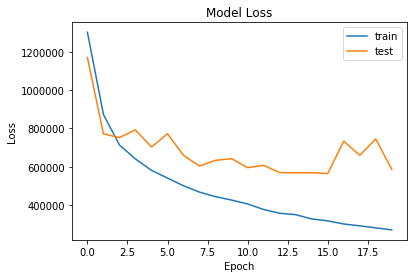

In [5]:
# store the results of each setting
train_losses = np.zeros(num_settings)
dev_losses = np.zeros(num_settings)

for setting in range(num_settings):
    # build the VGG16 network
    input_tensor = Input(shape=(224,224,3))
    model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)
    
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=(model.output_shape[1:])))


    # Output layer
    # We do random weight intialization
    top_model.add(Dropout(hp_dropout[setting]))
    top_model.add(Dense(hp_hidden[setting], activation='relu', kernel_initializer='glorot_uniform'))
    top_model.add(Dense(1, activation='linear', name='output', kernel_initializer='glorot_uniform'))
    
    # add the model on top of the convolutional base
    new_model = Model(inputs= model.input, outputs = top_model(model.output))

    # set the first 19 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in new_model.layers[:19]:
        layer.trainable = False

    # RMSprop optimizer
    new_model.compile(loss='mean_squared_error',
                      optimizer=optimizers.RMSprop(
                              lr=hp_lr[setting], 
                              rho=hp_rho[setting], 
                              epsilon=hp_epsilon[setting], 
                              decay=hp_decay[setting]))
    
    checkpoint_path = '/output/bikes-cnn-best.hdf5'
    
    # keep a checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path,
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')
    
    
    
    minibatch_size = hp_mbsize[setting]

    train_steps = math.ceil(len(train_indices) / minibatch_size)
    test_steps = math.ceil(len(test_indices) / minibatch_size)

    # fine-tune the model
    history = new_model.fit_generator(
        image_generator(train_indices, minibatch_size),
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=image_generator(test_indices, minibatch_size),
        nb_val_samples=test_steps,
        callbacks=[checkpoint])
    
    # store the training and dev losses for the last epoch (current model)
    train_losses[setting] = history.history['loss'][-1]
    dev_losses[setting] = history.history['val_loss'][-1]
    

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    print("==========")

### Evaluation Metrics

In [11]:
# get predictions on each batch yielded the validation generator.

validation_generator = image_generator(test_indices, minibatch_size)

predicted = []
actual = []

for step in range(test_steps):
    X, Y = next(validation_generator)
    curr_pred = new_model.predict(X)
    for entry in curr_pred:
        predicted.append(entry)
    for entry in Y:
        actual.append(entry)

In [12]:
predicted = np.array(predicted)
actual = np.array(actual)

MSE = mean_squared_error(predicted, actual)
MAE = mean_absolute_error(predicted, actual)
R2 = r2_score(actual, predicted)

print((MSE, MAE, R2))

(558631.18448112125, 405.49675095500072, 0.8309006306514245)
